# Machine Learning Engineer Nanodegree
## Capstone Project

**Virtual Machine (VM) preparation time prediction**

Sergey Sergeev  
December 31st, 2050

## I. Definition

### Project Overview

I work for the software development company, and we pay high attention to the test automation.
During 15 years of our product development and many implemented customer projects we accumulated a lot of autotests.
Autotests check various parts of our product in different environments, e.g. 

- 1, 2, 4, 8 VM clusters
- RedHat Enterprise Linux (RHEL) version 6 or 7
- different versions of Java (our primary programming language)
- etc...

Individual test's execution times vary from few minutes to several hours depending on complexity and size.

We built the private cloud (based on Openstack) for the continuous autotest execution and a simple Web interface to manage it.
On the dedicated page test engineer or developer may choose the list of tests he want to execute, number of virtual machines, versions of the 3rdparty software to be provisioned in the VMs, and so on.
After that the execution request is queued to be executed as soon as possible according to cloud capacity and current VM consumption.
As a result, engineer receives an email with the test report.
Test reports are also stored in some shared directory for reference, comparison and further analysis needs.     

### Problem Statement

For the higher cloud capacity utilization and better user experience we would like to have a model capable to predict overall test execution time.
This time is a sum of three:

- **Queue time (t1)**: time spent by an execution request in the queue waiting for the free cloud capacity
- **VM preparation time (t2)**: time to create a cluster of VMs and provision it with the requested 3rdparty software
- **Actual test execution time (t3)**: actual test execution till the final report   

In this project, I would focus on t2 estimation only, leaving t1 and t3 for a future.


Here is the brief workflow to prepare the solution:

- Clean up data: remove records about failed cluster creations
- Prepare benchmark model for final solution evaluation
- Remove useless features - e.g. success/failure indicator, number of attempts performed
- Transform original features
- Try various regression models provided by scikit-learn
- Tune the best model with grid search cross-validation
- Test final model on a testing set, compare with the benchmark model. 


### Metrics

[R^2 regression score](https://en.wikipedia.org/wiki/Coefficient_of_determination) (coefficient of determination) would be used as the main evaluation metric.

Additionally, [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error) and [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (root mean squared error) would be used for illustrative purposes.

## II. Analysis

### Data Exploration

In [1]:
# Shared imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import visuals as vs

%matplotlib inline
np.random.seed = 42

Let's load historical data from csv file and explore it.

In [2]:
dtype_corrections = {'with_postgresql_version': str}
data = pd.read_csv('clusters.csv', dtype = dtype_corrections)
print("The original dataset has {} data points with {} variables each.".format(*data.shape))


The original dataset has 1095 data points with 32 variables each.


In [3]:
data.dtypes

cluster_name               object
attempts                    int64
start_ts                    int64
end_ts                      int64
failed                       bool
completed                    bool
vm_count                    int64
build_name                 object
with_conda                   bool
with_conda_version         object
with_docker                  bool
with_docker_version        object
with_flavor                object
with_foundation              bool
with_foundation_version    object
with_gemfire                 bool
with_gemfire_version       object
with_image                 object
with_java_version          object
with_kubernetes              bool
with_kubernetes_version    object
with_memcached               bool
with_memcached_version     object
with_oracle                  bool
with_oracle_version        object
with_os_version            object
with_postgresql              bool
with_postgresql_version    object
with_tibco                   bool
with_tibco_ver

**Brief description of CSV columns:**
- `cluster_name`: The name to refer a particular cluster, primary key of the dataset
- `attempts`: Number of attempts performed to create and provision requested cluster, can be from `1` to `10`. The procedure gives up if a cluster is still failed after 10 subsequent attempts to build it
- `start_ts`: Start timestamp (in milliseconds from 1970, Jan, 1, 00:00:00 UTC)
- `end_ts`: End timestamp (in milliseconds from 1970, Jan, 1, 00:00:00 UTC)
- `failed`: Was it finished successfully or not?
- `completed`: Was it completed (even with failure) or interrupted?
- `vm_count`: Number of requested virtual machines in the cluster, can be from `1` to `26`
- `build_name`: Some unique version identifier in our build system

Other columns (started with `with_` prefix) describe how each of the cluster VM should be provisioned:
- `with_flavor`: Size of VM (in terms of # of CPU, RAM and HDD size)
- `with_os_version`: Operating system version to be used, can be `RHEL6.9`, `RHEL7.3`, `RHEL7.4`
- `with_image`: Custom base VM image to be used, or `_default_` if some prepared RHEL image is sufficient
- `with_java_version`: Java version. For example, `1.8.0_74`, `1.8.0_102`

The other `with_` columns come in pairs:
- `with_<X>` (indicator column): Should `X` software be installed and configured or not?
- `with_<X>_version` (version column): If `X` should be installed, of which version?


For example, [`with_docker = 'True'` and `with_docker_version='18.03.1.ce'`] means Docker 18.03.1.ce should be installed. 

Note, that the dataset also contains records such as [`with_docker = 'False'` and `with_docker_version='18.03.1.ce'`] - this means, that no Docker is needed (version column is ignored in this case).



In [4]:
optional_software = [
    'conda', 'docker', 'foundation', 
    'gemfire', 'kubernetes', 'memcached', 
    'oracle', 'postgresql', 'tibco', 'ulticom'
]

In [5]:
data.head(10)

,cluster_name,attempts,start_ts,end_ts,failed,completed,vm_count,build_name,with_conda,with_conda_version,...,with_memcached_version,with_oracle,with_oracle_version,with_os_version,with_postgresql,with_postgresql_version,with_tibco,with_tibco_version,with_ulticom,with_ulticom_version
0,kalexey.20181227174135,1,1545922452338,1545923103007,False,True,13,20181227_174049_Proj_2127259257,False,4.5.11,...,_default_,False,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
1,sdmitry.20181128184423,1,1543421316335,1543421667461,False,True,1,20181128_183651_Proj_1735463230,False,4.5.11,...,_default_,True,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_
2,igarus.20181221190350,2,1545408262310,1545409537436,False,True,14,20181220_115814_Proj_2696985,False,4.5.11,...,_default_,False,11.2.0,rhel7.4,False,9.5,False,8.4.5,True,9s65
3,sdmitry.20181211190002,1,1544544132560,1544544935177,False,True,9,20181211_161447_Proj_2631643,False,4.5.11,...,_default_,True,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_
4,abondar.20181207141530,1,1544181372440,1544181831985,False,True,4,20181207_083303_Proj_1027219150,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
5,kalexey.20181227072109,1,1545884532385,1545885127105,False,True,13,20181226_174418_Proj_2127259257,False,4.5.11,...,_default_,False,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
6,maximo.20181130172742,1,1543588116338,1543588336672,True,True,4,20181130_133648_Proj_2409,False,4.5.11,...,_default_,False,11.2.0,rhel6.9,False,9.5,False,8.4.5,False,_default_
7,edrojdina.20181206155824,1,1544102532566,1544102893012,False,True,3,20181206_143754_Proj_1027219150,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
8,nazarov.20181212152410,1,1544617573021,1544617977311,False,True,1,20181210_133821_Proj_73134446,False,4.5.11,...,_default_,True,11.2.0,rhel7.3,False,9.5,False,8.4.5,False,_default_
9,glungu.20181212000220.16171,2,1544570912999,1544571929867,False,True,15,20181212_000220_Proj_189425416,False,4.5.11,...,_default_,False,11.2.0,rhel7.4,False,9.5,False,8.4.5,False,_default_


Let's introduce the **target variable**: time (in seconds) to create a cluster as a difference between end timestamp and start timestamp

In [6]:
data['seconds'] = (data['end_ts'] - data['start_ts']) / 1000
## we may drop start_ts and end_ts now
data = data.drop(columns=['end_ts', 'start_ts'])

Let's explore statistics over **numerical** columns

In [7]:
data.describe()

,attempts,vm_count,seconds
count,1095.000000,1095.000000,1095.000000
mean,1.296804,5.042009,593.556932
std,1.198162,5.017708,372.183086
min,1.000000,1.000000,50.761000
25%,1.000000,1.000000,353.266000
50%,1.000000,3.000000,499.470000
75%,1.000000,9.000000,729.423000
max,10.000000,26.000000,4539.504000


Numerical feature statistics conclusions:
- Most of the requests were completed in 1-2 attempts
- VM count averages are relatively low (median = 3 and mean = 5) but the tail is heavy
- There are outliers in the dataset (look at the max `attempts` and max `seconds`)


Now, let's look at the **boolean and categorical** columns.


In [8]:
def get_unique(df, name = ""):
    df = pd.DataFrame(df.apply(lambda x: x.nunique()), columns = ['unique values'])
    df.index.name = name
    return df

display(get_unique(data.select_dtypes(include = 'bool'), "Boolean feature"))

,unique values
Boolean feature,
failed,2
completed,2
with_conda,1
with_docker,2
with_foundation,2
with_gemfire,2
with_kubernetes,2
with_memcached,1
with_oracle,2


As we can see, not all possible software indicators are used in the dataset.

Let's look at the software indicator correlations.

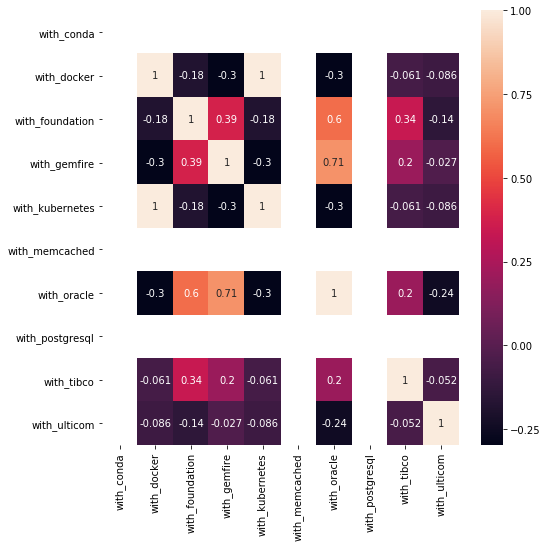

In [9]:
software_indicators = data[['with_{}'.format(x) for x in optional_software]]
corr = software_indicators.corr()

_, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, annot = True, ax = ax);

Conclusions about software indicator features:
- Optional software `conda`, `memcached` and `postgresql` were not requested for clusters we have in the dataset
- `docker` and `kebernetes` were used together all the time as the correlation is equal to 1.0
- there is a good `oracle`correlation with `gemfire` (0.71), and `oracle` with `foundation` (0.6)

In [10]:
cat_data = data.select_dtypes(include = 'object')
software_version_cols = ['with_{}_version'.format(x) for x in optional_software]
software_versions = cat_data[software_version_cols]
other_cat_data = cat_data.drop(columns = software_version_cols)

display(get_unique(other_cat_data, 'Categorical feature'))

,unique values
Categorical feature,
cluster_name,1095
build_name,488
with_flavor,1
with_image,1
with_java_version,5
with_os_version,3


`with_flavor` and `with_image` are always the same, so we can safely remove them from features

In [12]:
display(get_unique(software_versions, 'Optional software'))

,unique values
Optional software,
with_conda_version,1
with_docker_version,1
with_foundation_version,1
with_gemfire_version,5
with_kubernetes_version,1
with_memcached_version,2
with_oracle_version,1
with_postgresql_version,1
with_tibco_version,1


Most of the software versions don't vary, except of `gemfire` and `ulticom`. Two versions of `memcached` looks like an error in the dataset. Anyway, `memcached` is not used as we've seen above, so we can ignore it.

### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_

### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_

## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_


## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_


## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?